In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

return_number = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

def convert_date(d):
    try:
        return datetime.date(year=int(d[4:]), month=return_number[d[:3]], day=1)
    except:
        pass

loan['issue_d'] = loan['issue_d'].apply(convert_date)
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(convert_date)

loan = loan[loan.issue_d < datetime.date(2015,7,1)]
loan = loan[loan.issue_d >= datetime.date(2010,1,1)]

loan = loan[loan.term == ' 36 months']

loan['earliest_cr_line'] = loan.apply(lambda x: (x['issue_d'] - x['earliest_cr_line']).days, axis=1)

loan = loan[(loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Charged Off')]

loan = loan[loan.annual_inc < 1000000]

loan['ln_annual_inc'] = np.log(loan.annual_inc)

loan = loan[loan.revol_util < 150]
loan['ln_revol_bal'] = np.log(loan.revol_bal+1)

loan['ln_earliest_cr_line'] = np.log(loan.earliest_cr_line)

loan['ln_open_acc'] = np.log(loan.open_acc)

loan.rename(columns = {'delinq_2yrs': 'num_delinq_2yrs'}, inplace=True)
loan['delinq_2yrs'] = (loan['num_delinq_2yrs'] >= 1)

loan.rename(columns = {'pub_rec': 'num_pub_rec'}, inplace=True)
loan['pub_rec'] = (loan['num_pub_rec'] >= 1)

loan.rename(columns = {'inq_last_6mths': 'num_inq_last_6mths'}, inplace=True)
loan['inq_last_6mths'] = (loan['num_inq_last_6mths'] >= 1)

loan['target'] = (loan['loan_status'] == 'Fully Paid')

In [3]:
col_list = ['loan_amnt', 'int_rate', 'ln_annual_inc', 'dti', 'fico_range_high', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'num_inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'ln_open_acc', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']


In [4]:
# We will use 2010-2013 to tune our models, and save data from 2014 and the first 
# 6 months of 2015 for walk-forward testing

train = loan[loan.issue_d < datetime.date(2014, 1, 1)]
test = loan[(loan.issue_d >= datetime.date(2014, 1, 1)) & (loan.issue_d < datetime.date(2015, 1, 1))]
walkforward = loan[(loan.issue_d >= datetime.date(2015, 1, 1)) & (loan.issue_d < datetime.date(2015, 7, 1))]


In [5]:
y = train['target']
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2 = pd.concat([X1, train.int_rate, pd.get_dummies(train.grade)], axis=1)
X3 = pd.concat([X1, train.int_rate, pd.get_dummies(train.sub_grade)], axis=1)


In [6]:
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.grade)], axis=1)
X3_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.sub_grade)], axis=1)
y_test = test['target']

In [1]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time

start = time.time()
rfc1 = ensemble.RandomForestClassifier(max_depth=5, max_features=5, n_estimators=50)
scores = cross_val_score(rfc1, X1, y, cv=10)
time_elapsed = time.time()-start
print(scores.mean())
print(time_elapsed)



NameError: name 'X1' is not defined

In [8]:
rfc1.fit(X1, y)


for i in range(X1.shape[1]):
    print('{}: {}'.format(X1.columns[i], rfc1.feature_importances_[i]))


loan_amnt: 0.013480679729929793
ln_annual_inc: 0.26685870692150454
dti: 0.09826934957277426
fico_range_high: 0.38739938696612913
delinq_2yrs: 0.0008140913271462269
num_delinq_2yrs: 0.002971649881905773
ln_earliest_cr_line: 0.02384140783282142
inq_last_6mths: 0.031114306258451546
num_inq_last_6mths: 0.07464413275742153
ln_open_acc: 0.006613898789729678
pub_rec: 0.000455669103118355
num_pub_rec: 0.0011794362481755804
ln_revol_bal: 0.0226159453759721
revol_util: 0.05431627857199209
total_acc: 0.015425060662928055


In [9]:
X1.shape

(166313, 15)

In [10]:
rfc1.feature_importances_

array([0.01348068, 0.26685871, 0.09826935, 0.38739939, 0.00081409,
       0.00297165, 0.02384141, 0.03111431, 0.07464413, 0.0066139 ,
       0.00045567, 0.00117944, 0.02261595, 0.05431628, 0.01542506])

In [11]:
pred1 = rfc1.predict_proba(X1_test)

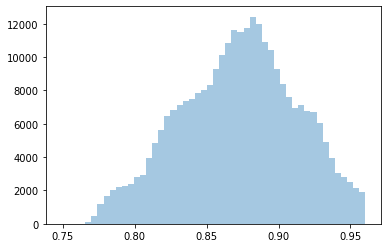

In [12]:
sns.distplot([x[1] for x in pred1], kde=False)

In [13]:
test['pred1'] = [x[1] for x in pred1]

In [31]:
test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt


In [15]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt

for letter in letters:
    thresh_m1_80 = np.percentile(test[test.grade == letter]['pred1'], q=80)

    thresh_m1_90 = np.percentile(test[test.grade == letter]['pred1'], q=90)

    thresh_m1_95 = np.percentile(test[test.grade == letter]['pred1'], q=95)
    
    thresh_m1_99 = np.percentile(test[test.grade == letter]['pred1'], q=99)

    print('-----------------  ' + letter + '  -----------------')
    print('')
    
    print('Naive Returns:       {}'.format(test[test.grade==letter]['pct_return'].mean()*100))
    
    print('')
    print('Model 1:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.pred1 >= thresh_m1_99)]['pct_return'].mean()*100))

    print('\n')

-----------------  A  -----------------

Naive Returns:       7.141438714524952

Model 1:
>80th percentile:    7.292928452678245
>90th percentile:    7.217038490320796
>95th percentile:    7.078008123241843
>99th percentile:    6.990534690588332


-----------------  B  -----------------

Naive Returns:       8.71693709483582

Model 1:
>80th percentile:    9.373381291211842
>90th percentile:    9.33425811188497
>95th percentile:    8.95148288943969
>99th percentile:    9.103823507948935


-----------------  C  -----------------

Naive Returns:       8.296905799613116

Model 1:
>80th percentile:    9.739432049341143
>90th percentile:    9.93254196315014
>95th percentile:    10.234894207722514
>99th percentile:    9.333306723147237


-----------------  D  -----------------

Naive Returns:       7.915659945631005

Model 1:
>80th percentile:    9.092677523399873
>90th percentile:    8.861318628838344
>95th percentile:    8.54832711587228
>99th percentile:    9.067521124133107


------------

In [16]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [1,2,3,5,7,10,15,20,25,30,40,50,70,90],
    'max_features': [2,3,4,5,7,10,15],
    'n_estimators': [50]
}

#rf2 = ensemble.RandomForestClassifier()

#rf2_random = RandomizedSearchCV(estimator=rf2, param_distributions = param_grid, n_iter=40, cv=5)

#rf2_random.fit(X1, y)

In [17]:
#rf2_random.best_params_

NameError: name 'rf2_random' is not defined

In [18]:
rf3 = ensemble.RandomForestClassifier(n_estimators=50, max_features=3, max_depth=10)

rf3.fit(X1, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
test['pred2'] = [x[1] for x in rf3.predict_proba(X1_test)]

def returns_by_grade(metric, grade, returns, thresh = [80, 90, 95]):
    for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        
        cutoffs = [np.percentile(metric[grade == letter], q=x) for x in thresh]
        
        print('--------------  ' + letter + '  --------------')
        print('')
    
        print('Naive Returns:             {}%'.format(round(returns[grade==letter].mean()*100, 2)))
        print('')
        
        for c in range(len(thresh)):
            print('{} Percent Cutoff:         {}%'.format(thresh[c], round(returns[(grade == letter) & (metric >= cutoffs[c])].mean()*100,2)))
            
        print('')
        
returns_by_grade(test.pred2, test.grade, test.pct_return)

#test[['pred2', 'grade', 'pct_return']]

In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test.target, test.pred2)

0.6428340173834258

In [21]:
roc_auc_score(test.target, test.pred1)

0.6348036653921332

Our model with optimized hyperparameters did improve the model somewhat over manual selection of parameteres.

In [22]:
rf4 = ensemble.RandomForestClassifier(max_depth=5, max_features=5, n_estimators=50)
rf4.fit(X2, y)

test['pred3'] = [x[1] for x in rf4.predict_proba(X2_test)]

roc_auc_score(test.target, test.pred3)

0.6713101951832501

In [23]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [1,2,3,5,7,10,15,20,25,30,40,50,70,90],
    'max_features': [2,3,4,5,7,10,15],
    'n_estimators': [50]
}

#rf5 = ensemble.RandomForestClassifier()

#rf5_random = RandomizedSearchCV(estimator=rf5, param_distributions = param_grid, n_iter=40, cv=3)

#rf5_random.fit(X2, y)

In [ ]:
#rf2_random.best_params_

In [24]:
rf6 = ensemble.RandomForestClassifier(n_estimators=500, max_features=4, max_depth=10)

rf6.fit(X2, y)

test['pred4'] = [x[1] for x in rf6.predict_proba(X2_test)]

roc_auc_score(test.target, test.pred4)

0.6728689185298052

In [27]:
def graph_by_grade(predictions, grade, target):
    pred = []
    act = []
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,4,1)
    plt.title("Overall")
    
    for i in range(21):
        
        lb = .58 + i*.02
        ub = .58 + (i+1)*.02
        sub = ((predictions >= lb)&(predictions < ub))
        pred_compliance = predictions[sub].mean()
        act_compliance = target[sub].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)

    plt.plot(pred, act)
    plt.plot(pred, pred)

    for letter in range(7):
        
        pred = []
        act = []
        ss = []
        
        for i in range(21):
            lb = .58 + i*.02
            ub = .58 + (i+1)*.02
            sub = ((predictions >= lb)&(predictions < ub)&(grade==letters[letter]))
            pred_compliance = predictions[sub].mean()
            act_compliance = target[sub].mean()
            pred.append(pred_compliance)
            act.append(act_compliance)

        plt.subplot(2,4,letter+2)
        plt.title('Loan Grade: {}'.format(letters[letter]))
        plt.plot(pred, act)
        plt.plot(pred, pred)
    
    plt.show()
    
graph_by_grade(test.pred4, test.grade, test.target)

In [26]:
returns_by_grade(test.pred4, test.grade, test.pct_return, [80, 90, 95, 99])

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         7.23%
90 Percent Cutoff:         7.15%
95 Percent Cutoff:         7.09%
99 Percent Cutoff:         6.93%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         9.51%
90 Percent Cutoff:         9.38%
95 Percent Cutoff:         9.43%
99 Percent Cutoff:         9.1%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         10.12%
90 Percent Cutoff:         10.38%
95 Percent Cutoff:         10.7%
99 Percent Cutoff:         11.58%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         10.77%
90 Percent Cutoff:         11.44%
95 Percent Cutoff:         12.07%
99 Percent Cutoff:         13.51%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         11.52%
90 Percent Cutoff:         12.28%
95 Percent Cutoff:         12.61%
99 Percent Cutof

In [30]:
def total_int_paid(n, i):
    ii = i/12
    return n*(ii * (1 + ii) ** n) / ((1+ii)**n - 1)-1

total_int_paid(36, .12)

test['total_int_paid'] = test.apply(lambda x: total_int_paid(36, x['int_rate']/100), axis=1)

test['ev4'] = test['pred4'] * test['total_int_paid'] - (1 - test['pred4']) * .37

In [65]:
returns_by_grade(test.ev4, test.grade, test.pct_return, [80, 90, 95, 99])

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         8.07%
90 Percent Cutoff:         8.4%
95 Percent Cutoff:         9.07%
99 Percent Cutoff:         9.75%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         10.66%
90 Percent Cutoff:         11.38%
95 Percent Cutoff:         12.0%
99 Percent Cutoff:         13.48%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         10.94%
90 Percent Cutoff:         11.52%
95 Percent Cutoff:         11.92%
99 Percent Cutoff:         12.4%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         11.0%
90 Percent Cutoff:         12.52%
95 Percent Cutoff:         13.51%
99 Percent Cutoff:         16.98%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         12.27%
90 Percent Cutoff:         12.92%
95 Percent Cutoff:         13.41%
99 Percent Cut

In [73]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [1,2,3,5,7,10,15,20,25,30,40,50,70,90],
    'max_features': [2,3,4,5,7,10,15],
    'n_estimators': [500]
}

rf7 = ensemble.RandomForestClassifier()

rf7_random = RandomizedSearchCV(estimator=rf7, param_distributions = param_grid, n_iter=40, cv=5)

rf7_random.fit(X3, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [74]:
rf7_random.best_params_

{'n_estimators': 500, 'max_features': 3, 'max_depth': 3}

In [99]:
#rf7_random.cv_results_['mean_fit_time', 'params', 'rank_test_score']

results = pd.DataFrame([rf7_random.cv_results_['mean_fit_time'],
                        [x['max_features'] for x in rf7_random.cv_results_['params']],
                        [x['max_depth'] for x in rf7_random.cv_results_['params']],
                        rf7_random.cv_results_['rank_test_score']
                       ])
results = results.transpose()
results.rename(columns = {0: 'run_time', 1: 'max_features', 2: 'max_depth', 3: 'rank'}, inplace=True)
results[results['rank']==1.0]

,run_time,max_features,max_depth,rank
0,17.621526,3.0,3.0,1.0
2,24.025836,2.0,7.0,1.0
5,70.698313,3.0,20.0,1.0
6,10.443843,2.0,1.0,1.0
10,14.234383,2.0,3.0,1.0
13,37.009632,10.0,3.0,1.0
16,18.465526,4.0,3.0,1.0
17,102.894903,4.0,25.0,1.0
18,18.855312,2.0,5.0,1.0
22,45.059657,15.0,3.0,1.0


In [103]:
rf8 = ensemble.RandomForestClassifier(n_estimators=500, max_features=3, max_depth=3)
rf8.fit(X3, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [105]:
test['pred8'] = [x[1] for x in rf8.predict_proba(X3_test)]

In [108]:
roc_auc_score(test.target, test.pred8)

0.6657023819616924

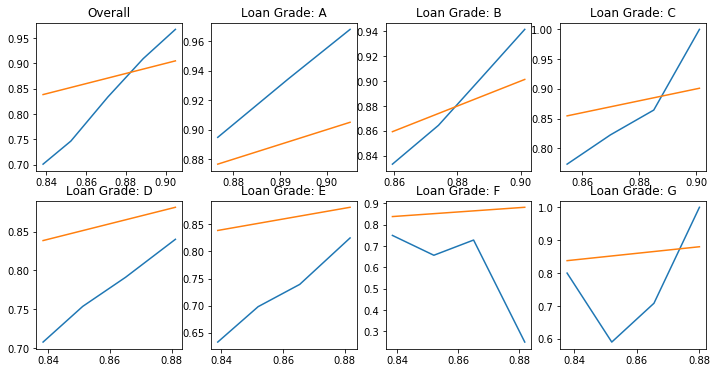

In [110]:
graph_by_grade(test.pred8, test.grade, test.target)

In [111]:
returns_by_grade(test.pred8, test.grade, test.pct_return, [80, 90, 95, 99])

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         7.18%
90 Percent Cutoff:         7.09%
95 Percent Cutoff:         6.89%
99 Percent Cutoff:         6.56%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         9.15%
90 Percent Cutoff:         9.31%
95 Percent Cutoff:         9.36%
99 Percent Cutoff:         8.56%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         9.2%
90 Percent Cutoff:         9.68%
95 Percent Cutoff:         9.94%
99 Percent Cutoff:         10.2%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         9.16%
90 Percent Cutoff:         9.27%
95 Percent Cutoff:         9.02%
99 Percent Cutoff:         9.81%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         9.03%
90 Percent Cutoff:         9.02%
95 Percent Cutoff:         8.85%
99 Percent Cutoff:        

In [112]:
test['ev8'] = test['pred8'] * test['total_int_paid'] - (1 - test['pred8']) * .37

returns_by_grade(test.ev8, test.grade, test.pct_return, [80, 90, 95, 99])

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         8.15%
90 Percent Cutoff:         8.46%
95 Percent Cutoff:         9.13%
99 Percent Cutoff:         10.07%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         10.4%
90 Percent Cutoff:         10.88%
95 Percent Cutoff:         11.06%
99 Percent Cutoff:         12.74%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         9.99%
90 Percent Cutoff:         10.76%
95 Percent Cutoff:         10.67%
99 Percent Cutoff:         12.31%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         9.58%
90 Percent Cutoff:         10.84%
95 Percent Cutoff:         11.68%
99 Percent Cutoff:         13.67%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         9.71%
90 Percent Cutoff:         9.83%
95 Percent Cutoff:         10.01%
99 Percent Cut

In [18]:
from imblearn.over_sampling import ADASYN, SMOTE

subset = X2.iloc[:20, :]

s_y = y[:20]

sampler = ADASYN(n_neighbors=4)
X2_rs, y_rs = sampler.fit_sample(X2, y)

In [20]:
print("Original Sample - Paid: {}".format(sum(y == True)))
print("Original Sample - Default: {}".format(sum(y == False)))
print("Rebalanced Sample - Paid: {}".format(sum(y_rs == True)))
print("Rebalanced Sample - Paid: {}".format(sum(y_rs == False)))

Original Sample - Paid: 145709
Original Sample - Default: 20604
Rebalanced Sample - Paid: 145709
Rebalanced Sample - Paid: 143189


In [23]:
rf9 = ensemble.RandomForestClassifier(n_estimators=500, max_features=4, max_depth=10)

rf9.fit(X2_rs, y_rs)

test['pred5'] = [x[1] for x in rf9.predict_proba(X2_test)]

NameError: name 'roc_auc_score' is not defined

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test.target, test.pred5)

0.6540009991907855

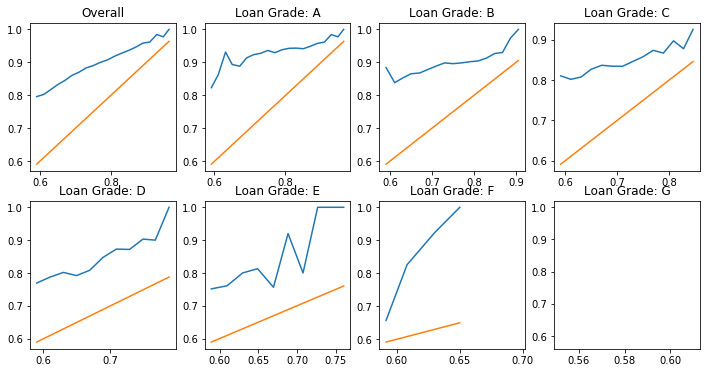

In [29]:
graph_by_grade(test.pred5, test.grade, test.target)

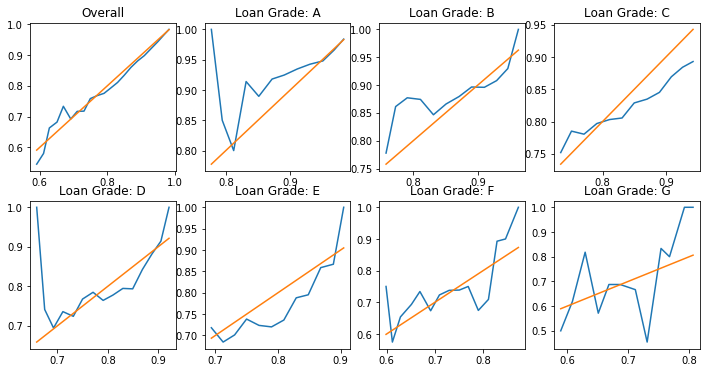

In [35]:
test['pred5_adj'] = test['pred5']/(test['pred5'] + ((1 - test['pred5']) / 3))
graph_by_grade(test.pred5_adj, test.grade, test.target)

In [33]:
returns_by_grade(test.pred5, test.grade, test.pct_return, [80, 90, 95, 99])

--------------  A  --------------

Naive Returns:             7.45%

80 Percent Cutoff:         7.4%
90 Percent Cutoff:         7.45%
95 Percent Cutoff:         7.17%
99 Percent Cutoff:         7.19%

--------------  B  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         10.43%
90 Percent Cutoff:         10.88%
95 Percent Cutoff:         10.89%
99 Percent Cutoff:         10.95%

--------------  C  --------------

Naive Returns:             9.31%

80 Percent Cutoff:         11.56%
90 Percent Cutoff:         11.88%
95 Percent Cutoff:         12.5%
99 Percent Cutoff:         13.95%

--------------  D  --------------

Naive Returns:             9.33%

80 Percent Cutoff:         12.2%
90 Percent Cutoff:         13.9%
95 Percent Cutoff:         15.3%
99 Percent Cutoff:         17.61%

--------------  E  --------------

Naive Returns:             9.5%

80 Percent Cutoff:         12.43%
90 Percent Cutoff:         13.78%
95 Percent Cutoff:         16.11%
99 Percent Cuto

In [36]:
predictions = rf9.predict(X2_test)

In [37]:
predictions[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [38]:
print(sum(predictions==True))
print(sum(predictions==False))

153624
8838


In [39]:
8/161

0.049689440993788817

In [41]:
sum(y_test)/len(y_test)

0.8627555982322019